# Question 3.2

In [171]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX



from sklearn.metrics import mean_squared_error


### Part 3.2 (a)

In [ ]:
cpi = pd.read_csv("/Users/stephenandrews/Downloads/MIT Schoolwork/Spring 2025/6.3732/6373Pset3/data/PriceStats_CPI.csv")

cpi['date'] = pd.to_datetime(cpi['date'])

cpi.set_index('date', inplace=True)
monthly_cpi = cpi.resample('ME')['CPI'].first()

monthly_cpi_nolog = monthly_cpi.dropna()
monthly_cpi = np.log1p(monthly_cpi_nolog)

print(monthly_cpi)

date
2008-07-31    4.615121
2008-08-31    4.620306
2008-09-30    4.616346
2008-10-31    4.614976
2008-11-30    4.604924
                ...   
2018-05-31    4.749282
2018-06-30    4.753396
2018-07-31    4.754975
2018-08-31    4.755042
2018-09-30    4.755592
Freq: ME, Name: CPI, Length: 123, dtype: float64


Training period: 2008-07-31 to 2013-08-31
Testing period: 2013-09-30 to 2018-09-30
                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                   62
Model:                     AutoReg(2)   Log Likelihood                 248.594
Method:               Conditional MLE   S.D. of innovations              0.004
Date:                Sat, 05 Apr 2025   AIC                           -489.188
Time:                        02:32:12   BIC                           -480.811
Sample:                    09-30-2008   HQIC                          -485.911
                         - 08-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0334      0.079      0.425      0.671      -0.121       0.188
CPI.L1         1.5208      0.109     13.891     

/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/2175869339.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = params[0]  # start with the intercept
/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/2175869339.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat += params[lag] * monthly_cpi.loc[prev_time]


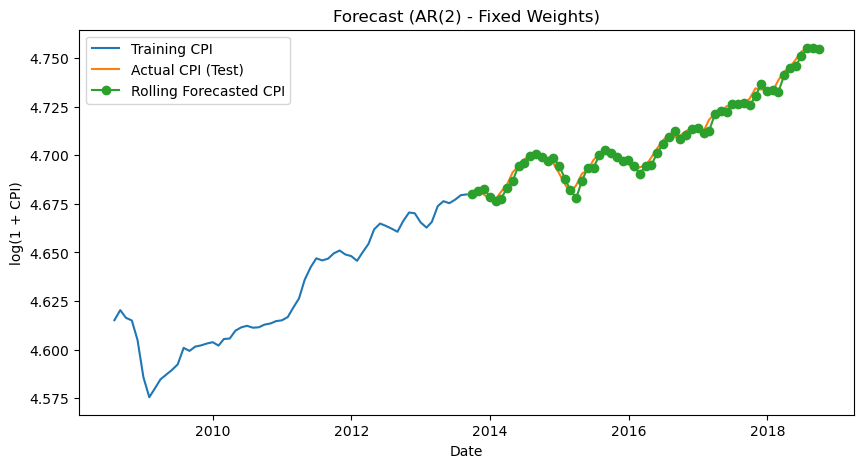

In [182]:
# Set the desired lag order here
lag_order = 2  # Change this number for AR(1), AR(2), etc.

# Assume 'monthly_cpi' is your pandas Series with a DatetimeIndex (month-end dates)

# Define the cutoff date for training and testing
cutoff_date = pd.Timestamp('2013-09-30')
train = monthly_cpi[monthly_cpi.index < cutoff_date]
test  = monthly_cpi[monthly_cpi.index >= cutoff_date]

print("Training period:", train.index.min().date(), "to", train.index.max().date())
print("Testing period:", test.index.min().date(), "to", test.index.max().date())

# Fit the AR model on the training data with the specified lag order
model = AutoReg(train, lags=lag_order, old_names=False)
model_fit = model.fit()
print(model_fit.summary())

# Extract the fixed model parameters:
# model_fit.params[0] is the intercept, and model_fit.params[1] to model_fit.params[lag_order] are the AR coefficients.
params = model_fit.params

# Rolling one-step-ahead forecast using actual observed values for the lags
predictions = []
for t in test.index:
    yhat = params[0]  # start with the intercept
    # Loop over each lag from 1 to lag_order
    for lag in range(1, lag_order + 1):
        # Use MonthEnd to correctly obtain the previous month-end date for the given lag
        prev_time = t - pd.offsets.MonthEnd(lag)
        if prev_time in monthly_cpi.index:
            yhat += params[lag] * monthly_cpi.loc[prev_time]
        else:
            raise ValueError(f"Actual CPI value for {prev_time.date()} is not available.")
    predictions.append(yhat)

# Evaluate forecast performance using Mean Squared Error
mse = mean_squared_error(test, predictions)
print("\n MSE:", mse)

# Plot the actual CPI and the rolling forecast
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Training CPI')
plt.plot(test.index, test, label='Actual CPI (Test)')
plt.plot(test.index, predictions, label='Rolling Forecasted CPI', marker='o')
plt.title(f'Forecast (AR({lag_order}) - Fixed Weights)')
plt.xlabel('Date')
plt.ylabel('log(1 + CPI)')
plt.legend()
plt.savefig("parta forecast")
plt.show()



Fitting AR(1) model on training data...
                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                   62
Model:                     AutoReg(1)   Log Likelihood                 243.154
Method:               Conditional MLE   S.D. of innovations              0.004
Date:                Sat, 05 Apr 2025   AIC                           -480.308
Time:                        02:36:09   BIC                           -473.976
Sample:                    08-31-2008   HQIC                          -477.827
                         - 08-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0405      0.090     -0.451      0.652      -0.217       0.136
CPI.L1         1.0090      0.019     51.984      0.000       0.971       1.047
           

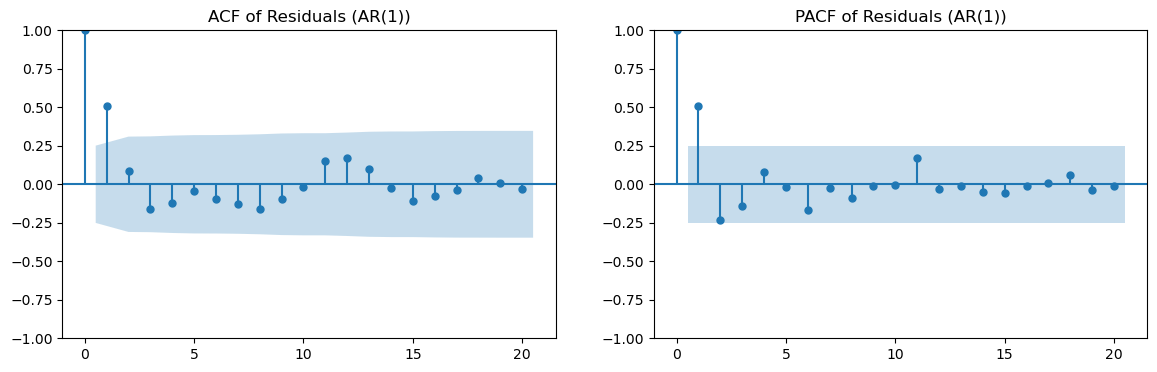

Rolling one-step forecast MSE for AR(1): 0.00001

Fitting AR(2) model on training data...
                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                   62
Model:                     AutoReg(2)   Log Likelihood                 248.594
Method:               Conditional MLE   S.D. of innovations              0.004
Date:                Sat, 05 Apr 2025   AIC                           -489.188
Time:                        02:36:09   BIC                           -480.811
Sample:                    09-30-2008   HQIC                          -485.911
                         - 08-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0334      0.079      0.425      0.671      -0.121       0.188
CPI.L1         1.5208      0.109     13.8

/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = params[0]
/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat += params[lag] * monthly_cpi.loc[prev_time]


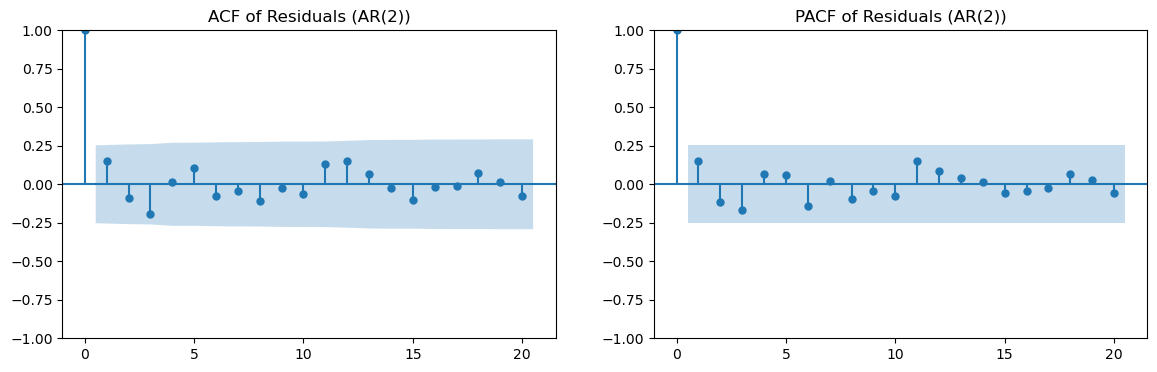

Rolling one-step forecast MSE for AR(2): 0.00001

Fitting AR(3) model on training data...
                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                   62
Model:                     AutoReg(3)   Log Likelihood                 247.711
Method:               Conditional MLE   S.D. of innovations              0.004
Date:                Sat, 05 Apr 2025   AIC                           -485.421
Time:                        02:36:09   BIC                           -475.034
Sample:                    10-31-2008   HQIC                          -481.366
                         - 08-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0132      0.076      0.173      0.863      -0.136       0.163
CPI.L1         1.6729      0.122     13.6

/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = params[0]
/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat += params[lag] * monthly_cpi.loc[prev_time]


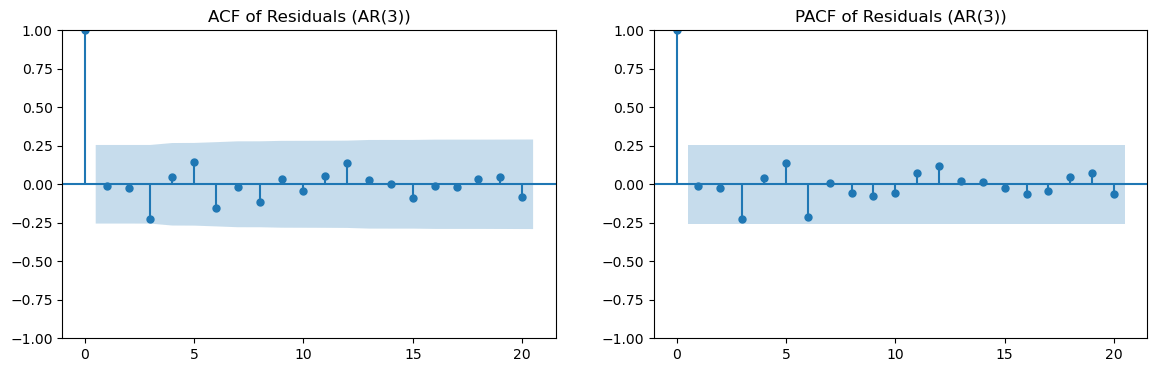

/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = params[0]
/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat += params[lag] * monthly_cpi.loc[prev_time]


Rolling one-step forecast MSE for AR(3): 0.00001

Fitting AR(4) model on training data...
                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                   62
Model:                     AutoReg(4)   Log Likelihood                 243.570
Method:               Conditional MLE   S.D. of innovations              0.004
Date:                Sat, 05 Apr 2025   AIC                           -475.139
Time:                        02:36:10   BIC                           -462.777
Sample:                    11-30-2008   HQIC                          -470.324
                         - 08-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0043      0.078     -0.056      0.956      -0.157       0.149
CPI.L1         1.6601      0.130     12.7

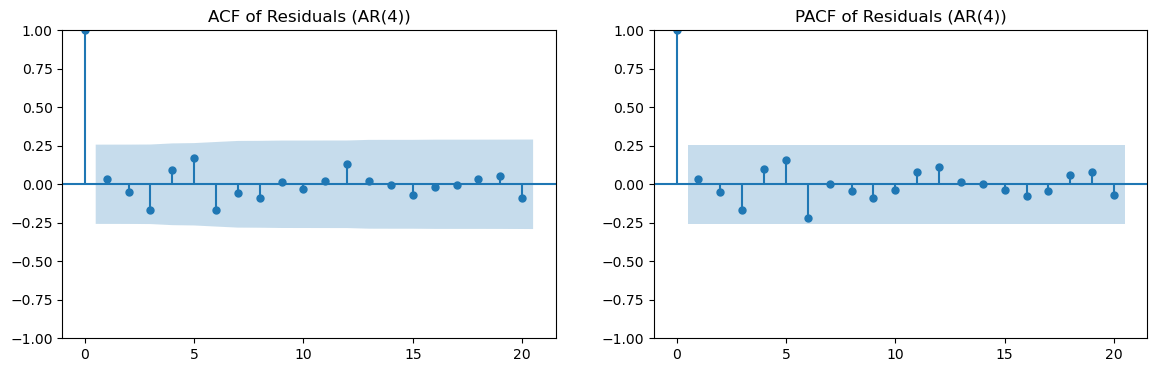

/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = params[0]
/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat += params[lag] * monthly_cpi.loc[prev_time]


Rolling one-step forecast MSE for AR(4): 0.00001

Fitting AR(5) model on training data...
                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                   62
Model:                     AutoReg(5)   Log Likelihood                 243.451
Method:               Conditional MLE   S.D. of innovations              0.003
Date:                Sat, 05 Apr 2025   AIC                           -472.902
Time:                        02:36:10   BIC                           -458.601
Sample:                    12-31-2008   HQIC                          -467.344
                         - 08-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0221      0.075      0.295      0.768      -0.125       0.169
CPI.L1         1.6945      0.122     13.8

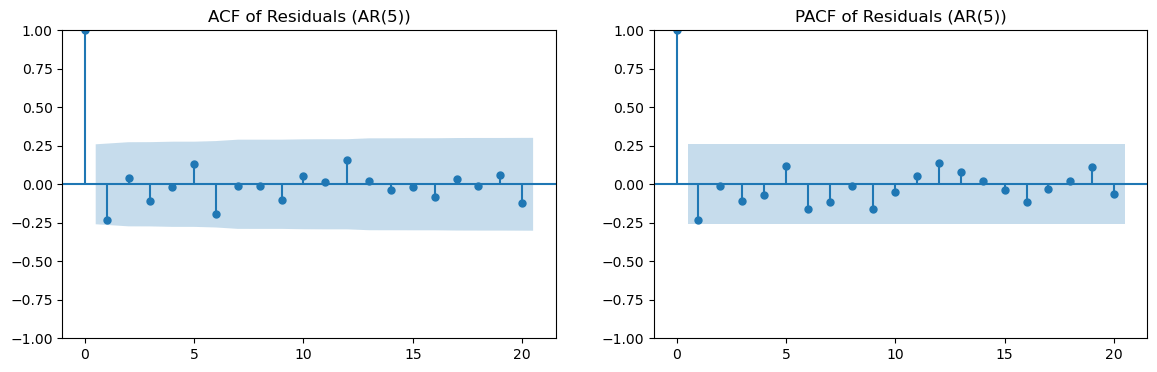

Rolling one-step forecast MSE for AR(5): 0.00001

Fitting AR(6) model on training data...
                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                   62
Model:                     AutoReg(6)   Log Likelihood                 252.727
Method:               Conditional MLE   S.D. of innovations              0.003
Date:                Sat, 05 Apr 2025   AIC                           -489.455
Time:                        02:36:10   BIC                           -473.252
Sample:                    01-31-2009   HQIC                          -483.173
                         - 08-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0417      0.060      0.692      0.489      -0.076       0.160
CPI.L1         1.4631      0.104     14.0

/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = params[0]
/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat += params[lag] * monthly_cpi.loc[prev_time]


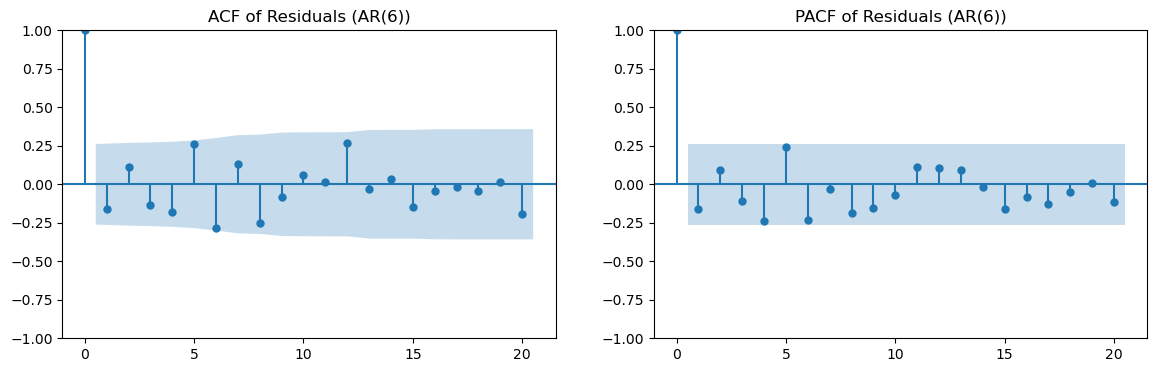

Rolling one-step forecast MSE for AR(6): 0.00001

Summary of Rolling One-Step Forecast MSE by AR order:
AR(1): MSE = 0.00001
AR(2): MSE = 0.00001
AR(3): MSE = 0.00001
AR(4): MSE = 0.00001
AR(5): MSE = 0.00001
AR(6): MSE = 0.00001


/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = params[0]
/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat += params[lag] * monthly_cpi.loc[prev_time]


In [186]:
orders = range(1, 7)
forecast_mse = {}

for order in orders:
    print("\n" + "="*60)
    print(f"Fitting AR({order}) model on training data...")
    # Fit the AR model on training data with the current order
    model = AutoReg(train, lags=order, old_names=False)
    model_fit = model.fit()
    print(model_fit.summary())
    
    # Plot ACF and PACF of residuals to examine if additional lags are needed.
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    plot_acf(model_fit.resid, ax=ax[0], lags=20)
    ax[0].set_title(f'ACF of Residuals (AR({order}))')
    plot_pacf(model_fit.resid, ax=ax[1], lags=20)
    ax[1].set_title(f'PACF of Residuals (AR({order}))')
    plt.show()
    
    # Extract fixed model parameters (the weights trained on data before cutoff)
    params = model_fit.params

    # Compute rolling one-step forecasts on the test set.
    # We use the actual observed values for the lags (from monthly_cpi) without updating the model weights.
    forecast_indices = []
    predictions = []
    for t in test.index:
        # Initialize forecast with the intercept (params[0])
        yhat = params[0]
        valid = True
        # Loop over each lag from 1 to the current order
        for lag in range(1, order + 1):
            # Subtract lag months using MonthEnd to get the proper month-end date.
            prev_time = t - pd.offsets.MonthEnd(lag)
            if prev_time in monthly_cpi.index:
                yhat += params[lag] * monthly_cpi.loc[prev_time]
            else:
                valid = False
                break
        if valid:
            forecast_indices.append(t)
            predictions.append(yhat)
    
    # Align the forecasts with the corresponding actual test values.
    test_aligned = test[test.index.isin(forecast_indices)]
    if len(predictions) > 0 and len(test_aligned) > 0:
        mse = mean_squared_error(test_aligned, predictions)
        forecast_mse[order] = mse
        print(f"Rolling one-step forecast MSE for AR({order}): {mse:.5f}")
    else:
        print(f"Not enough test data to compute rolling forecast for AR({order}).")

# Display a summary of the forecast performance for each AR order.
print("\n" + "="*60)
print("Summary of Rolling One-Step Forecast MSE by AR order:")
for order, mse in forecast_mse.items():
    print(f"AR({order}): MSE = {mse:.5f}")

### Part 3.2 (b)

In [189]:
t10 = pd.read_csv("/Users/stephenandrews/Downloads/MIT Schoolwork/Spring 2025/6.3732/6373Pset3/data/T10YIE.csv")

t10['DATE'] = pd.to_datetime(t10['DATE'])
t10.set_index('DATE', inplace=True)
t10['T10YIE'] = pd.to_numeric(t10['T10YIE'], errors='coerce')

t10avg = t10.resample('ME')['T10YIE'].mean()
t10avg = t10avg.dropna()

t5 = pd.read_csv("/Users/stephenandrews/Downloads/MIT Schoolwork/Spring 2025/6.3732/6373Pset3/data/T5YIE.csv")

t5['DATE'] = pd.to_datetime(t5['DATE'])
t5.set_index('DATE', inplace=True)
t5['T5YIE'] = pd.to_numeric(t5['T5YIE'], errors='coerce')

t5avg = t5.resample('ME')['T5YIE'].mean()
t5avg = t5avg.dropna()

monthly_pricestats_avg = cpi.resample('ME')['PriceStats'].mean()

predictions = pd.Series(predictions, index=test.index)

print(predictions)



date
2013-09-30    4.679775
2013-10-31    4.682253
2013-11-30    4.683801
2013-12-31    4.678793
2014-01-31    4.677717
                ...   
2018-05-31    4.744636
2018-06-30    4.751220
2018-07-31    4.755221
2018-08-31    4.754640
2018-09-30    4.754729
Freq: ME, Length: 61, dtype: float64


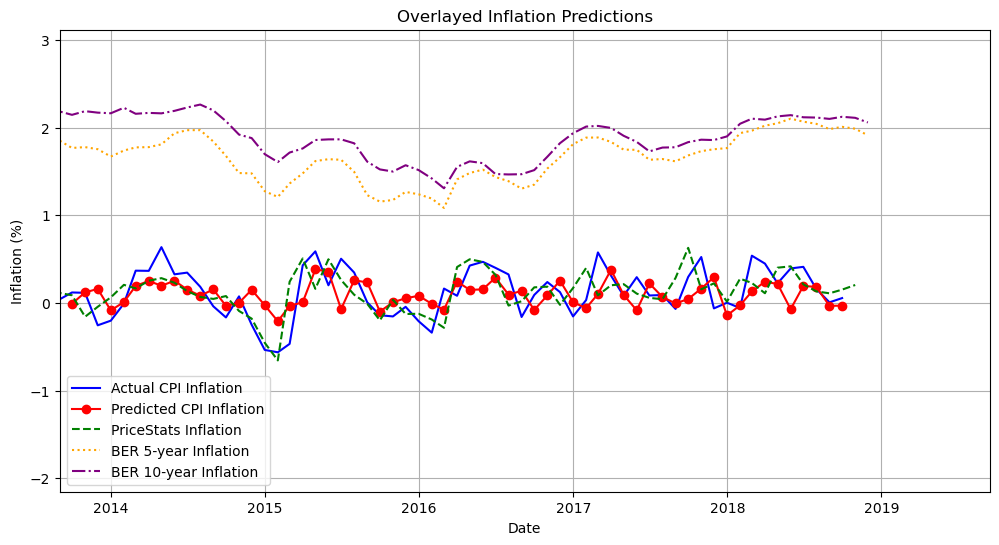

In [191]:
# 1. Actual CPI Inflation (from log-transformed CPI)
#    Using log-differences approximates the percentage change.
actual_inflation = monthly_cpi.diff() * 100  # drop first NA later
actual_inflation = actual_inflation.dropna()

# 2. Predicted CPI Inflation (from predicted log(CPI) values)
#    For each forecast date, we compute:
#       predicted_inflation = 100 * (predicted_log(CPI)_t - actual_log(CPI)_(t-1))
predicted_inflation_values = []
predicted_dates = []
for t in predictions.index:
    # Get previous month-end date (using MonthEnd to ensure we match the dates)
    prev_time = t - pd.offsets.MonthEnd(1)
    if prev_time in monthly_cpi.index:
        infl = 100 * (predictions.loc[t] - monthly_cpi.loc[prev_time])
        predicted_inflation_values.append(infl)
        predicted_dates.append(t)
    else:
        # If no matching previous date is available, skip (or handle appropriately)
        continue
predicted_inflation = pd.Series(predicted_inflation_values, index=predicted_dates)

# 3. PriceStats Inflation
#    Here we assume PriceStats is given in levels (not in log scale),
#    so compute the simple percentage change.
# price_stats_inflation = monthly_pricestats.diff() * 100
# price_stats_inflation = price_stats_inflation.dropna()

log_price_stats = np.log1p(monthly_pricestats_avg)
price_stats_inflation = 100 * log_price_stats.diff()

# 4. BER series (5-year and 10-year) are assumed to already be in percentage terms.
#    No transformation is needed.

# -------------------------------
# Overlayed Graph
# -------------------------------

plt.figure(figsize=(12, 6))

# Plot actual CPI inflation
plt.plot(actual_inflation.index, actual_inflation, label='Actual CPI Inflation', color='blue')

# Plot predicted CPI inflation
plt.plot(predicted_inflation.index, predicted_inflation, label='Predicted CPI Inflation', 
         color='red', marker='o', linestyle='-')

# Plot PriceStats inflation
plt.plot(price_stats_inflation.index, price_stats_inflation, label='PriceStats Inflation', 
         color='green', linestyle='--')

# Plot BER 5-year inflation
plt.plot(t5avg.index, t5avg, label='BER 5-year Inflation', 
         color='orange', linestyle=':')

# Plot BER 10-year inflation
plt.plot(t10avg.index, t10avg, label='BER 10-year Inflation', 
         color='purple', linestyle='-.')

plt.title('Overlayed Inflation Predictions')
plt.xlabel('Date')
plt.xlim(pd.Timestamp('2013-09-01'), None)
plt.ylabel('Inflation (%)')
plt.legend()
plt.grid(True)
plt.savefig("Overlayed Inflation")
plt.show()


### Part 3.2 (c)

In [165]:
t10_first = t10.resample('ME')['T10YIE'].first()
t10_first = t10_first.dropna()

t5_first = t5.resample('ME')['T5YIE'].first()
t5_first = t5_first.dropna()

t5_first = t5_first.loc['2008-07-31':'2018-09-30']
t10_first = t10_first.loc['2008-07-31':'2018-09-30']

monthly_pricestats_first = cpi.resample('ME')['PriceStats'].first()
monthly_pricestats_first = monthly_pricestats_first.loc['2008-07-31':'2018-09-30']
# monthly_pricestats_first = monthly_pricestats_first.dropna()

            T10YIE  T5YIE  PriceStats
2008-07-31    2.52   2.66   100.00000
2008-08-31    2.34   2.17    99.85761
2008-09-30    2.05   1.72    99.65436
2008-10-31    1.51   0.95    99.72428
2008-11-30    0.87  -0.95    97.99059
...            ...    ...         ...
2018-05-31    2.16   2.09   115.39380
2018-06-30    2.09   2.06   115.83110
2018-07-31    2.14   2.07   115.86930
2018-08-31    2.13   2.00   116.09710
2018-09-30    2.10   1.99   116.12450

[123 rows x 3 columns]
Training period: 2008-07-31 to 2013-08-31
Testing period: 2013-09-30 to 2018-09-30
                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                   62
Model:                   AutoReg-X(2)   Log Likelihood                 279.271
Method:               Conditional MLE   S.D. of innovations              0.002
Date:                Sat, 05 Apr 2025   AIC                           -544.542
Time:                        02:46:30   BI

/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/3000901235.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = params[0]  # Start with the intercept
/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/3000901235.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat += params[lag] * monthly_cpi.loc[prev_time]
/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/3000901235.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

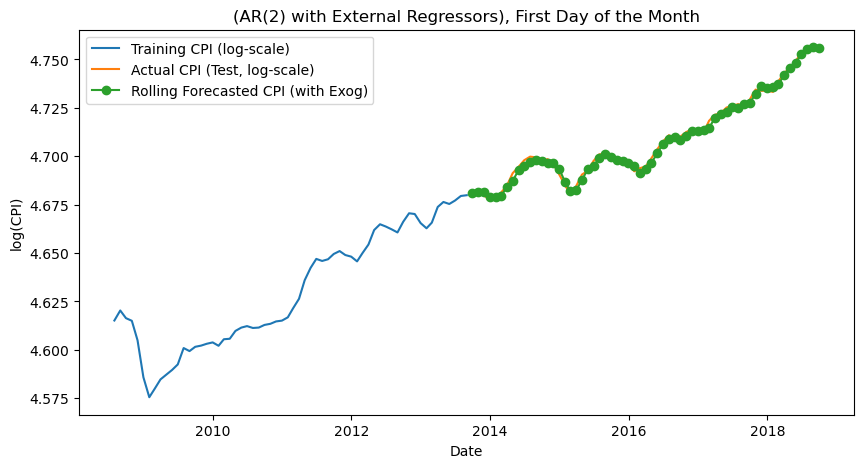

In [193]:
# First day of the Month

# -----------------------------
# Assumptions:
# - monthly_cpi: Your log-transformed CPI series (with month-end dates).
# - t10_first, t5_first, monthly_pricestats_first: Your external regressor series,
#   also indexed by month-end dates.
# -----------------------------

# For example, if they aren’t already in log form, you might have:
# monthly_cpi = np.log(monthly_cpi_original)

# Combine the external regressors into one DataFrame.
exog = pd.concat([t10_first, t5_first, monthly_pricestats_first], axis=1)
print(exog)

exog.columns = ['t10_first', 't5_first', 'monthly_pricestats_first']

# -----------------------------
# Define training and test sets
# -----------------------------
lag_order = 2  # AR order (change as needed)
cutoff_date = pd.Timestamp('2013-09-30')

# Split CPI series (assumed to be in log-scale)
train = monthly_cpi[monthly_cpi.index < cutoff_date]
test  = monthly_cpi[monthly_cpi.index >= cutoff_date]

# Split the exogenous data similarly
exog_train = exog[exog.index < cutoff_date]
exog_test  = exog[exog.index >= cutoff_date]

print("Training period:", train.index.min().date(), "to", train.index.max().date())
print("Testing period:", test.index.min().date(), "to", test.index.max().date())

# -----------------------------
# Fit AR model with exogenous regressors
# -----------------------------
model = AutoReg(train, lags=lag_order, exog=exog_train, old_names=False)
model_fit = model.fit()
print(model_fit.summary())

# For reference, inspect the parameters.
# Typically, for an AR(2) with 3 exogenous variables, the parameters will be ordered as:
# [Intercept, L1.monthly_cpi, L2.monthly_cpi, t10_first, t5_first, monthly_pricestats_first]
params = model_fit.params
print("Model parameters:\n", params)

# -----------------------------
# Rolling one-step-ahead forecast (fixed weights)
# -----------------------------
# Here, we forecast each test period using:
# - The AR part: using actual observed lagged CPI values.
# - The exogenous part: using the exog value for that forecast period.
predictions = []
for t in test.index:
    yhat = params[0]  # Start with the intercept
    # Add AR terms using lagged CPI values.
    for lag in range(1, lag_order + 1):
        # Use MonthEnd to ensure correct month-end alignment.
        prev_time = t - pd.offsets.MonthEnd(lag)
        if prev_time in monthly_cpi.index:
            yhat += params[lag] * monthly_cpi.loc[prev_time]
        else:
            raise ValueError(f"Actual CPI value for {prev_time.date()} is not available.")
    # Add exogenous regressors.
    if t in exog_test.index:
        # The coefficients for exog are assumed to follow the AR lags.
        # For AR(2), the next coefficients are at positions 3, 4, and 5.
        yhat += params[lag_order + 1] * exog_test.loc[t, 't10_first']
        yhat += params[lag_order + 2] * exog_test.loc[t, 't5_first']
        yhat += params[lag_order + 3] * exog_test.loc[t, 'monthly_pricestats_first']
    else:
        raise ValueError(f"Exogenous regressor not available for {t.date()}")
    predictions.append(yhat)

# Convert predictions to a Series with the same index as the test set.
predicted_log = pd.Series(predictions, index=test.index)

# Evaluate forecast performance using Mean Squared Error.
mse = mean_squared_error(test, predicted_log)
print("\nMSE:", mse)

# -----------------------------
# Plot the results
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Training CPI (log-scale)')
plt.plot(test.index, test, label='Actual CPI (Test, log-scale)')
plt.plot(test.index, predicted_log, label='Rolling Forecasted CPI (with Exog)', marker='o')
plt.title(f'(AR({lag_order}) with External Regressors), First Day of the Month')
plt.xlabel('Date')
plt.ylabel('log(CPI)')
plt.legend()
plt.savefig("AR first")
plt.show()


In [168]:
t5_avg = t5avg.loc['2008-07-31':'2018-09-30']
t10_avg = t10avg.loc['2008-07-31':'2018-09-30']

monthly_pricestats_avg = monthly_pricestats_avg.loc['2008-07-31':'2018-09-30']

              T10YIE     T5YIE  PriceStats
2008-07-31  2.438636  2.462727   99.921037
2008-08-31  2.209524  1.993810   99.727196
2008-09-30  1.836190  1.330952   99.770512
2008-10-31  1.061818 -0.027727   99.011287
2008-11-30  0.638333 -1.398889   97.221704
...              ...       ...         ...
2018-06-30  2.117619  2.067619  115.836927
2018-07-31  2.114286  2.042381  115.990274
2018-08-31  2.099130  1.982609  116.118484
2018-09-30  2.123158  2.008421  116.296103
2018-10-31       NaN       NaN  116.535927

[124 rows x 3 columns]
Training period: 2008-07-31 to 2013-08-31
Testing period: 2013-09-30 to 2018-09-30
                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                   62
Model:                   AutoReg-X(2)   Log Likelihood                 277.482
Method:               Conditional MLE   S.D. of innovations              0.002
Date:                Sat, 05 Apr 2025   AIC                  

/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/2846756100.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = params[0]  # Start with the intercept
/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/2846756100.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat += params[lag] * monthly_cpi.loc[prev_time]
/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/2846756100.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

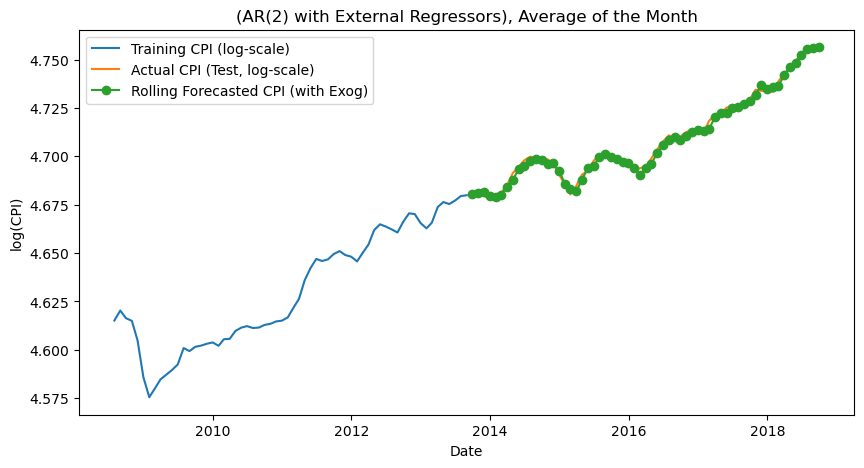

In [192]:
# Average over Month

exog = pd.concat([t10_avg, t5_avg, monthly_pricestats_avg], axis=1)
print(exog)

exog.columns = ['t10_avg', 't5_avg', 'monthly_pricestats_avg']

# -----------------------------
# Define training and test sets
# -----------------------------
lag_order = 2  # AR order (change as needed)
cutoff_date = pd.Timestamp('2013-09-30')

# Split CPI series (assumed to be in log-scale)
train = monthly_cpi[monthly_cpi.index < cutoff_date]
test  = monthly_cpi[monthly_cpi.index >= cutoff_date]

# Split the exogenous data similarly
exog_train = exog[exog.index < cutoff_date]
exog_test  = exog[exog.index >= cutoff_date]

print("Training period:", train.index.min().date(), "to", train.index.max().date())
print("Testing period:", test.index.min().date(), "to", test.index.max().date())

# -----------------------------
# Fit AR model with exogenous regressors
# -----------------------------
model = AutoReg(train, lags=lag_order, exog=exog_train, old_names=False)
model_fit = model.fit()
print(model_fit.summary())

# For reference, inspect the parameters.
# Typically, for an AR(2) with 3 exogenous variables, the parameters will be ordered as:
# [Intercept, L1.monthly_cpi, L2.monthly_cpi, t10_first, t5_first, monthly_pricestats_first]
params = model_fit.params
print("Model parameters:\n", params)

# -----------------------------
# Rolling one-step-ahead forecast (fixed weights)
# -----------------------------
# Here, we forecast each test period using:
# - The AR part: using actual observed lagged CPI values.
# - The exogenous part: using the exog value for that forecast period.
predictions = []
for t in test.index:
    yhat = params[0]  # Start with the intercept
    # Add AR terms using lagged CPI values.
    for lag in range(1, lag_order + 1):
        # Use MonthEnd to ensure correct month-end alignment.
        prev_time = t - pd.offsets.MonthEnd(lag)
        if prev_time in monthly_cpi.index:
            yhat += params[lag] * monthly_cpi.loc[prev_time]
        else:
            raise ValueError(f"Actual CPI value for {prev_time.date()} is not available.")
    # Add exogenous regressors.
    if t in exog_test.index:
        # The coefficients for exog are assumed to follow the AR lags.
        # For AR(2), the next coefficients are at positions 3, 4, and 5.
        yhat += params[lag_order + 1] * exog_test.loc[t, 't10_avg']
        yhat += params[lag_order + 2] * exog_test.loc[t, 't5_avg']
        yhat += params[lag_order + 3] * exog_test.loc[t, 'monthly_pricestats_avg']
    else:
        raise ValueError(f"Exogenous regressor not available for {t.date()}")
    predictions.append(yhat)

# Convert predictions to a Series with the same index as the test set.
predicted_log = pd.Series(predictions, index=test.index)

# Evaluate forecast performance using Mean Squared Error.
mse = mean_squared_error(test, predicted_log)
print("\nMSE:", mse)

# -----------------------------
# Plot the results
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Training CPI (log-scale)')
plt.plot(test.index, test, label='Actual CPI (Test, log-scale)')
plt.plot(test.index, predicted_log, label='Rolling Forecasted CPI (with Exog)', marker='o')
plt.title(f'(AR({lag_order}) with External Regressors), Average of the Month')
plt.xlabel('Date')
plt.ylabel('log(CPI)')
plt.legend()
plt.savefig("AR avg")
plt.show()


### Part 3.2 (d)

            T10YIE  T5YIE  PriceStats
2008-07-31    2.52   2.66   100.00000
2008-08-31    2.34   2.17    99.85761
2008-09-30    2.05   1.72    99.65436
2008-10-31    1.51   0.95    99.72428
2008-11-30    0.87  -0.95    97.99059
...            ...    ...         ...
2018-05-31    2.16   2.09   115.39380
2018-06-30    2.09   2.06   115.83110
2018-07-31    2.14   2.07   115.86930
2018-08-31    2.13   2.00   116.09710
2018-09-30    2.10   1.99   116.12450

[123 rows x 3 columns]
Training period: 2008-07-31 to 2013-08-31
Testing period: 2013-09-30 to 2018-09-30
                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                   62
Model:                   AutoReg-X(2)   Log Likelihood                 279.271
Method:               Conditional MLE   S.D. of innovations              0.002
Date:                Sat, 05 Apr 2025   AIC                           -544.542
Time:                        02:53:13   BI

/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/1396670364.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = params[0]  # Start with the intercept
/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/1396670364.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat += params[lag] * monthly_cpi.loc[prev_time]
/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/1396670364.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

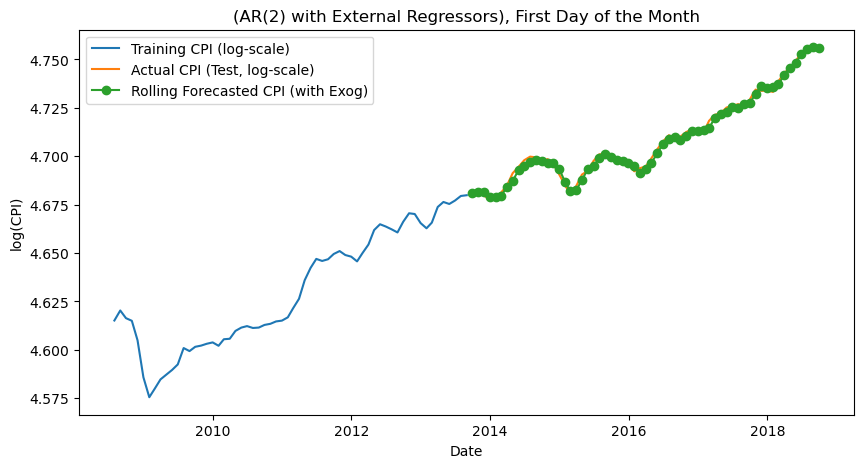

In [ ]:
# -----------------------------
# Data Setup
# -----------------------------
# Combine your external regressors into one DataFrame.
exog = pd.concat([t10_first, t5_first, monthly_pricestats_first], axis=1)
print(exog)

exog.columns = ['t10_first', 't5_first', 'monthly_pricestats_first']

# -----------------------------
# Define training and test sets
# -----------------------------
lag_order = 2  # AR order (change as needed)
cutoff_date = pd.Timestamp('2013-09-30')

# Split CPI series (assumed to be in log-scale)
train = monthly_cpi[monthly_cpi.index < cutoff_date]
test  = monthly_cpi[monthly_cpi.index >= cutoff_date]

# Split the exogenous data similarly
exog_train = exog[exog.index < cutoff_date]
exog_test  = exog[exog.index >= cutoff_date]

print("Training period:", train.index.min().date(), "to", train.index.max().date())
print("Testing period:", test.index.min().date(), "to", test.index.max().date())

# -----------------------------
# Fit AR model with exogenous regressors
# -----------------------------
model = AutoReg(train, lags=lag_order, exog=exog_train, old_names=False)
model_fit = model.fit()
print(model_fit.summary())

# For reference, inspect the parameters.
# Typically, for an AR(2) with 3 exogenous variables, the parameters will be ordered as:
# [Intercept, L1.monthly_cpi, L2.monthly_cpi, t10_first, t5_first, monthly_pricestats_first]
params = model_fit.params
print("Model parameters:\n", params)

# -----------------------------
# Rolling one-step-ahead forecast (fixed weights)
# -----------------------------
# Here, we forecast each test period using:
# - The AR part: using actual observed lagged CPI values.
# - The exogenous part: using the exog value for that forecast period.
predictions = []
for t in test.index:
    yhat = params[0]  # Start with the intercept
    # Add AR terms using lagged CPI values.
    for lag in range(1, lag_order + 1):
        # Use MonthEnd to ensure correct month-end alignment.
        prev_time = t - pd.offsets.MonthEnd(lag)
        if prev_time in monthly_cpi.index:
            yhat += params[lag] * monthly_cpi.loc[prev_time]
        else:
            raise ValueError(f"Actual CPI value for {prev_time.date()} is not available.")
    # Add exogenous regressors.
    if t in exog_test.index:
        # The coefficients for exog are assumed to follow the AR lags.
        # For AR(2), the next coefficients are at positions 3, 4, and 5.
        yhat += params[lag_order + 1] * exog_test.loc[t, 't10_first']
        yhat += params[lag_order + 2] * exog_test.loc[t, 't5_first']
        yhat += params[lag_order + 3] * exog_test.loc[t, 'monthly_pricestats_first']
    else:
        raise ValueError(f"Exogenous regressor not available for {t.date()}")
    predictions.append(yhat)

# Convert predictions to a Series with the same index as the test set.
predicted_log = pd.Series(predictions, index=test.index)

# Evaluate forecast performance using Mean Squared Error.
mse = mean_squared_error(test, predicted_log)
print("\nMSE:", mse)

# -----------------------------
# Plot the results
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Training CPI (log-scale)')
plt.plot(test.index, test, label='Actual CPI (Test, log-scale)')
plt.plot(test.index, predicted_log, label='Rolling Forecasted CPI (with Exog)', marker='o')
plt.title(f'(AR({lag_order}) with External Regressors), First Day of the Month with MA term')
plt.xlabel('Date')
plt.ylabel('log(CPI)')
plt.legend()
plt.savefig("AR first with MA")
plt.show()

